In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [3]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images, labels = images.to(device), labels.to(device)

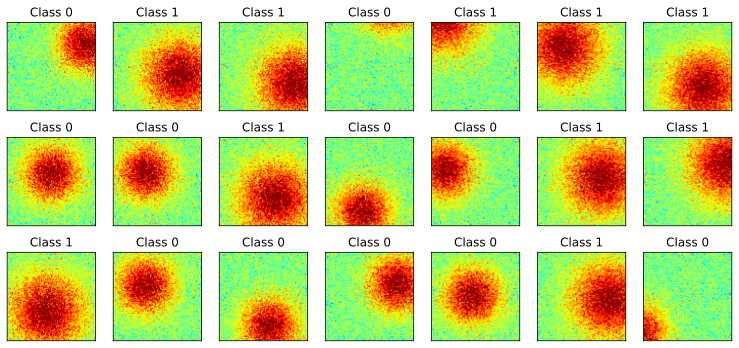

In [4]:
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [16]:
len(images)

2000

In [32]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size= 0.2, random_state = 42)

train_data = TensorDataset(train_data, train_label)
test_data = TensorDataset(test_data, test_label)

batch_size = 32
train_loader = DataLoader(train_data, shuffle = True, drop_last = True, batch_size = batch_size)
test_loader = DataLoader(test_data, drop_last = True, batch_size = test_data.tensors[0].shape[0])




In [33]:
print(train_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[0].shape)

torch.Size([1600, 1, 91, 91])
torch.Size([400, 1, 91, 91])


In [34]:
print(train_loader.dataset.tensors[1].shape)

torch.Size([1600, 1])


In [35]:
def makeTheNet():
  class GausNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.enc = nn.Sequential(
          nn.Conv2d(1, 6, 3, padding = 1),
          nn.ReLU(),
          nn.AvgPool2d(2,2),
          nn.Conv2d(6, 4, 3, padding = 1),
          nn.ReLU(),
          nn.AvgPool2d(2, 2),
          nn.Flatten(),
          nn.Linear(22*22*4, 50),
          nn.Linear(50, 1)
      )



    def forward(self, x):
      x = self.enc(x)
      return x

  net = GausNet()
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

  return net, lossfun, optimizer

In [37]:
net, lossfun, optimizer = makeTheNet()
net.cuda()
X, y = next(iter(train_loader))
yHat = net(X)
loss = lossfun(yHat, y)
print(yHat.shape)
print('')
print(loss)

torch.Size([32, 1])

tensor(0.6906, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [38]:
summary(net, (1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [42]:
def function2trainTheModel():
  numepochs = 10
  net, lossfun, optimizer = makeTheNet()
  net.cuda()
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)
  trainAcc = torch.zeros(numepochs)
  testAcc = torch.zeros(numepochs)

  for epochi in range(numepochs):
    batchLoss = []
    batchAcc = []

    for X, y in train_loader:
      yHat = net(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      batchLoss.append(loss.item())
      batchAcc.append(torch.mean(((yHat>0) == y).float()).item())


    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = 100 * np.mean(batchAcc)


  X, y = next(iter(test_loader))
  with torch.no_grad():
    yHat = net(X)
    loss = lossfun(yHat, y)
  
  print(loss)
  testLoss[epochi] = loss.item()
  testAcc[epochi] = 100 * torch.mean(((yHat> 0) == y).float()).item()

  return trainLoss, testLoss, trainAcc, testAcc

In [43]:
trainLoss, testLoss, trainAcc, testAcc = function2trainTheModel()

tensor(0.0364, device='cuda:0')


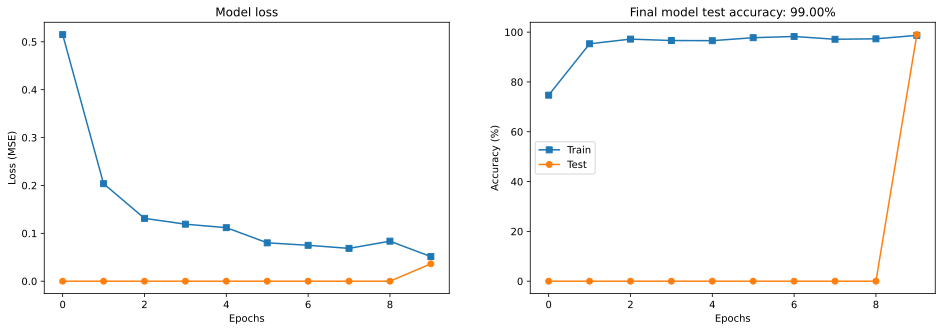

In [47]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

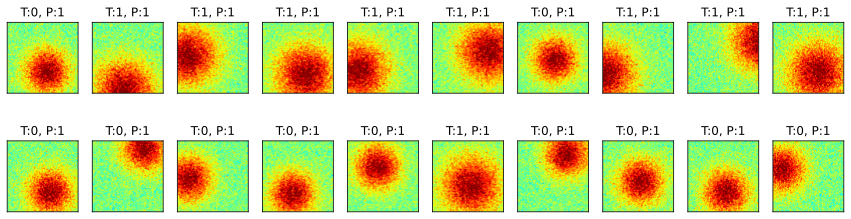

In [49]:
X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  G = G.cpu()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [53]:
print(net)

layer1W = net.enc[0].weight.cpu()
layer3W = net.enc[3].weight.cpu()

print(' ')
print(layer1W.shape)
print(layer3W.shape)

GausNet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


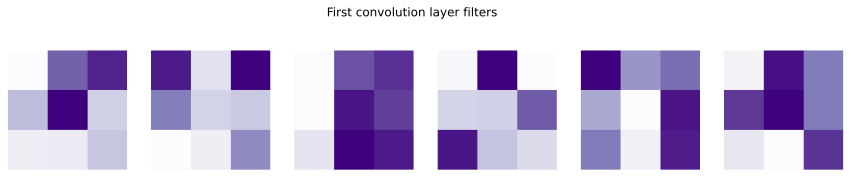

In [54]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Purples')
  ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)


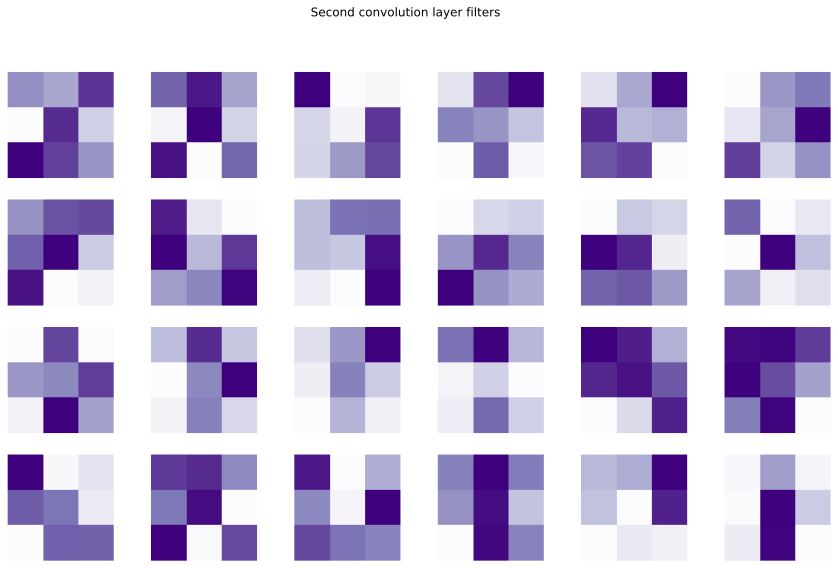

In [56]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  print(idx)
  axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
  axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()

In [58]:
np.unravel_index?